In [4]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score, adjusted_rand_score
import networkx as nx
import torch
import torch.nn as nn
import pandas as pd


from libraries.preprocess import load_ts_dataset, distance_matrix, epsilon_graph_hard, epsilon_graph_mean
from libraries.nmf import nmf, nmf_sklearn, semi_nmf, sym_nmf, rgnmf_multi, kernel_nmf, sparse_nmf
from libraries.clustering_algos import kmeans, gaussian_mixture, spectral_clustering, node2vec_clustering
from libraries.deepnmf import DeepNMF, DeepNMFLoss, DANMF, DANMFLoss, deep_autoencoder_nmf, deep_nmf

In [18]:
# This cell defines the methods to test on the PTB dataset and their hyperparameters. You can comment unwanted methods

# hyperparameters for epsilon experiments
MAX_LEN = 100
# list of methods and parameters
methods = {
    deep_nmf: [0.01, 1000, False], # lr, nb_iters, visualize
    deep_autoencoder_nmf: [0.01, 1000, 1.0, False], # lr, nb_iters, sparsity_regularization, visualize
    node2vec_clustering: [128, 50, 25, 0.5, 2, False], # n_dim embedding, n length of walks, length of walks, p, q, direct
    kmeans: [False], # direct
    gaussian_mixture: [False], # direct
    spectral_clustering: [False], # direct
    nmf_sklearn: [1000], # max_iter
    semi_nmf: [1000, False], # max_iters, safeguard
    sym_nmf: [1e-4, 0.1, 1000], # lr, sigma, max_iters
    #rgnmf_multi: [1e-2, 1, 1000, False, 1e-4, 1e4], # alpha, bera, max_iters, safeguard, lower_limit, higher_limit
    kernel_nmf: ['gaussian', 1.0, 3, 1.0, 1.0, 500], # kernel, sigma, degree, alpha, beta, max_iters
    sparse_nmf: [0.1, 0.1, 100], # beta, eta, max_iters
}

# import PTB dataset
data_normal = pd.read_csv('ptbdb_normal.csv').iloc[:MAX_LEN].to_numpy()
data_abnormal = pd.read_csv('ptbdb_abnormal.csv').iloc[:MAX_LEN].to_numpy()
data = np.concatenate([data_normal, data_abnormal], axis=0)

true_labels = np.concatenate([np.zeros(MAX_LEN), np.ones(MAX_LEN)])

ts_length = len(data[0])
# suffle dataset
shuffl = np.concatenate([data, np.expand_dims(true_labels, axis=1)], axis=1)
np.random.shuffle(shuffl)

data, true_labels = shuffl[:, :ts_length - 1], shuffl[:, -1].astype(np.int64)

In [19]:
def test(methods, data, true_labels):
    # parameters for the testing
    epsilon_factor = 0.9
    
    # output dict
    output_dict = {}
    dataset_name = 'PTB'
    print(f'Starting dataset {dataset_name}')
    # prepare output_dict
    output_dict[dataset_name] = {}
    
    # build normalized distance matrix
    dist = distance_matrix(data)
    dist_n = dist / np.max(dist)

    # print number of classes of the dataset
    nb_clusters = len(np.unique(true_labels))
    print(f'Dataset has {nb_clusters} clusters !')
    
    # random partition to compare
    random_score = np.mean([rand_score(true_labels, np.random.randint(low=0, high=nb_clusters, size=len(dist))) for i in range(1000)])
    
    # test each method
    for method in methods.keys():
        print(f'Starting method {method.__name__}')
        eps = []
        residuals = []
        rands = []
        preds = []

        # start epsilon sweep
        for i in range(50):
            ep = epsilon_factor**i
            Anp = epsilon_graph_hard(dist_n, epsilon=ep)
            W, H, residual = method(Anp, nb_clusters, *(methods.get(method)))
            residuals.append(residual)
            eps.append(ep)
            preds.append(np.argmax(W, axis=1))
            rands.append(rand_score(true_labels, np.argmax(W, axis=1)))
        
        # find best epsilon
        idx = np.argmax(rands)

        output_dict[dataset_name][method] = {'eps': eps,
                                            'residuals': residuals,
                                            'rands': rands,
                                            'preds': preds,
                                            'best_epsilon': eps[idx],
                                            'epsilon_quantile': len(dist_n.flatten()[dist_n.flatten() <= eps[idx]]) / len(dist_n.flatten())
                                            }
    
    return output_dict



In [20]:
# sometimes kmeans raises a package error, but relaunching the cell should work
import warnings
warnings.simplefilter('ignore')
output = test(methods, data, true_labels)

Starting dataset PTB
Dataset has 2 clusters !
Starting method deep_nmf
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initi

PTB


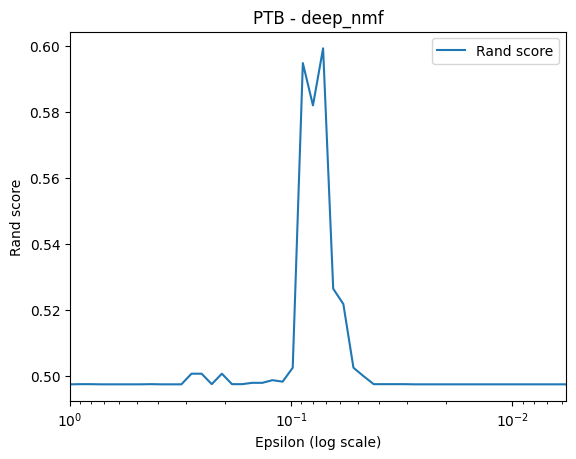

In [22]:
for dataset_name in output.keys():
    print(dataset_name)
    for method in output[dataset_name].keys():
        
        eps = output[dataset_name].get(method).get('eps')
        rands = output[dataset_name].get(method).get('rands')
        
        # Plotting in log scale
        plt.plot(eps, rands, label='Rand score')
        plt.xscale('log')  # Set x-axis to log scale
        plt.xlabel('Epsilon (log scale)')
        plt.ylabel('Rand score')
        plt.title(f'{dataset_name} - {method.__name__}')
        plt.xlim(eps[0], eps[-1])
        plt.legend()
        plt.show()
        break


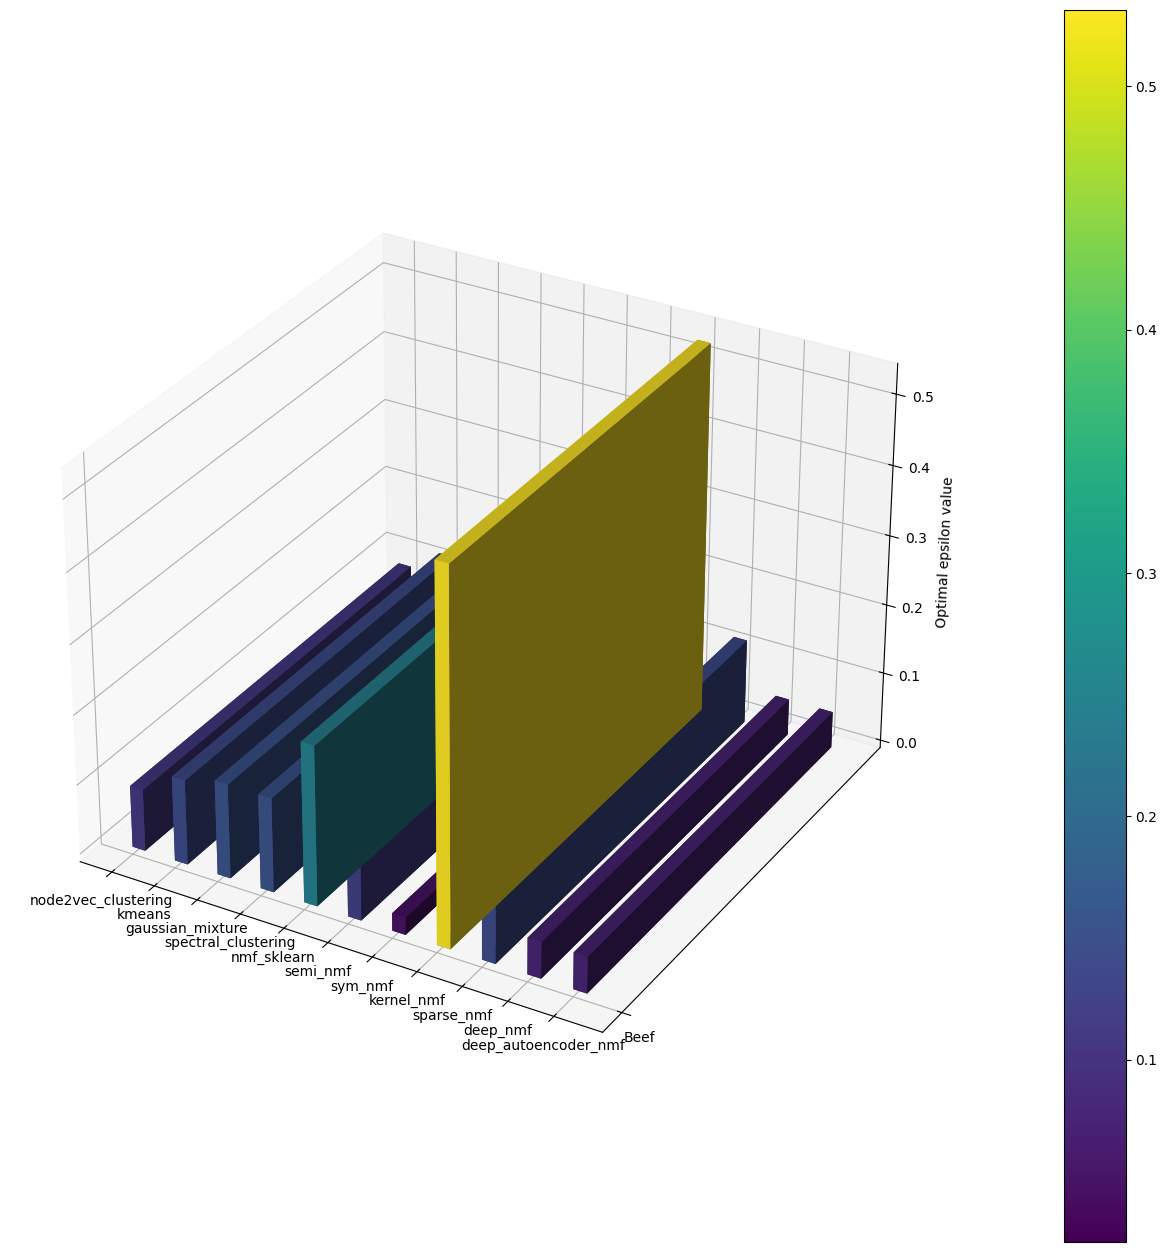

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

method_names = [method.__name__ for method in methods.keys()]
dataset_names = list(hyperparameters.keys())

data = np.array([[output[dataset_name][method]['best_epsilon'] for method in methods.keys()] for dataset_name in dataset_names])

# Create a meshgrid for x and y
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

# Adjust the bar width and separation
bar_width = 0.3
bar_gap = 0.0

# Create a 3D plot
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D bars with color based on height
for xi, yi, zi, value in zip(x, y, z, data.flatten()):
    color = plt.cm.viridis(value / data.max())  # Use viridis colormap, adjust as needed
    ax.bar3d(xi, yi, zi, bar_width, bar_width, value, shade=True, color=color, zsort='max')

# Create a color scale along the z-axis
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(data.flatten())
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)


# Customize x and y axis ticks and labels
ax.set_xticks(np.arange(len(method_names)))
ax.set_yticks(np.arange(len(dataset_names)))

ax.set_xticklabels(method_names)
ax.set_yticklabels(dataset_names)
# Set labels
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
ax.set_zlabel('Optimal epsilon value')

# Show the plot
plt.show()


In [ ]:
plt.imshow(data)
plt.show()